In [1]:
import finesse
from finesse.gaussian import BeamParam
from finesse.knm import Map
from finesse.gaussian import optimise_HG00_q_scipy, optimise_HG00_q

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from scipy.optimize import fsolve, minimize
from finesse.gaussian import HGMode
import scipy
import scipy.integrate as integrate
from sympy import symbols, I, conjugate, simplify, lambdify
import sympy as sp

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import numpy as np

finesse.configure(plotting=True)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
kat = finesse.Model()
kat.modes(maxtem=3)

alpha = 10
w0 = 1e-3
kat.parse(
    f"""
    gauss input L0.p1.o priority=1 w0={w0} z=-1

    l L0 P=1

    s s0 L0.p1 BS.p1 L=1

    bs BS R=1 T=0 alpha={alpha} Rc=30

    s s1 BS.p2 Point.p1 L=1
    
    nothing Point
    
    noxaxis()
    """
)

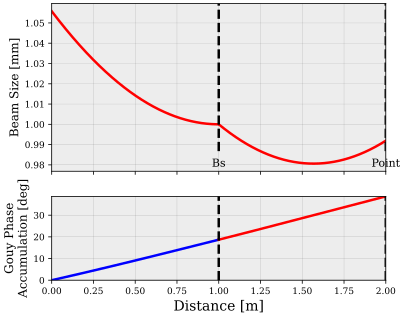

In [3]:
tsy = finesse.tracing.tools.propagate_beam(
    from_node=kat.L0.p1.o, to_node=kat.Point.p2.o, direction="x"
)

fig, (ax1, ax2)  = tsy.plot()
background_color = '#ededed'

ax1.patch.set_facecolor(background_color)
ax2.patch.set_facecolor(background_color)

# ax2.set_ylim([-5, 95])
# ax2.set_yticks([0, 30, 60, 90])

ax2.set_xlabel('Distance [m]', fontsize=14)
ax1.set_ylabel('Beam Size [mm]', fontsize=12)
ax2.set_ylabel('Gouy Phase\nAccumulation [deg]', fontsize=12)

for line in ax1.get_lines()+ax2.get_lines():
    line.set_linewidth(2.5)

fig.set_size_inches(6, 5);

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
ax1.set_subplotspec(gs[0])
ax2.set_subplotspec(gs[1])

text_objects = ax1.texts
for text_object in text_objects:
    text_object.set_text(text_object.get_text().capitalize())

In [4]:
kat0 = kat.deepcopy()
kat0.BS.alpha = 0
trace0 = kat0.beam_trace()
gouys = kat0.compute_space_gouys()
print(gouys[kat0.spaces.s1])

gouy_1 = gouys[kat0.spaces.s1]["x"]
qx0_1, qy0_1 = trace0[kat0.Point.p2.o]
qx0_1, qy0_1

{'x': 19.944481253519776, 'y': 19.944481253519776}


(❮BeamParam (w0=981.17 um, w=992.88 um, z=440.48 mm, nr=1, λ=1.064 um) at 0x147007b10❯,
 ❮BeamParam (w0=981.17 um, w=992.88 um, z=440.48 mm, nr=1, λ=1.064 um) at 0x147005310❯)

$$
M =\left(\begin{array}{ll}1 & 0 \\ \frac{-2}{R_{e}} & 1\end{array}\right)
$$
$$
\mbox{where \,}R_{e} = \begin{cases}
   R\cos\theta &\mbox{Tangential/Horizontal} \\
   \frac{R}{\cos\theta} &\mbox{Sagittal/Vertical}
   \end{cases}
$$

$$
q_{refl} = \frac{Aq+B}{Cq+D} = \begin{cases}
   \frac{q}{\frac{-2q}{R} + 1} &\mbox{Normal Incidence} \\
   \frac{q}{\frac{-2q}{R\cos\theta} + 1} &\mbox{Tangential/Horizontal} \\
   \frac{q}{\frac{-2q\cos\theta}{R} + 1} &\mbox{Sagittal/Vertical}
   \end{cases}
$$

$$
\mbox{Mode Mismatch \,}\mathbf{M}=\frac{\left|q_{1}-q_{2}\right|^{2}}{\left|q_{1}-q_{2}^{*}\right|^{2}}
$$

$$
\begin{aligned} 
\mbox{Astig} = \frac{\left|q_{t}-q_{s}\right|^{2}}{\left|q_{t}-q_{s}^{*}\right|^{2}}
= & \frac{\left(z^{2} + z_{R}^{2}\right)^{2} \sin^{4}{\left(\theta \right)}}{- R^{2} z_{R}^{2} \sin^{2}{\left(\theta \right)} + R^{2} z_{R}^{2} + z^{4} \sin^{4}{\left(\theta \right)} + 2 z^{2} z_{R}^{2} \sin^{4}{\left(\theta \right)} + z_{R}^{4} \sin^{4}{\left(\theta \right)}} \\
& \approx \frac{\left(z^{2} + z_{R}^{2}\right)^{2}}{R^{2} z_{R}^{2}} \cdot \frac{\sin^{4}{\left(\theta \right)}}{\cos^{2}{\left(\theta \right)}} \\
& = \left(\frac{z R_{c}}{z_{R} R}\right)^{2} \cdot \frac{\sin^{4}{\left(\theta \right)}}{\cos^{2}{\left(\theta \right)}}
\end{aligned}
$$
$$
\mbox{where } q = z+iz_{R} \mbox{ is the input beam parameter. This is astigmatism between \,} q_{t} \mbox{ and } q_{s} \mbox{ due to angle of indicence\,}  \theta \mbox{ on curved mirrors.}
$$

In [5]:
def mismatchBP(q, R, theta):
    q0 = q/(-2*q/R + 1)
    q1 = q/(-2*q/(R*np.cos(theta)) + 1)
    q2 = q/(-2*q*np.cos(theta)/R + 1)
    return BeamParam.mismatch(q0, q1), BeamParam.mismatch(q0, q2), BeamParam.mismatch(q1, q2)

In [6]:
# Define symbols
z, zR, R, theta = symbols('z z_R R theta', real=True)
q = symbols('q', complex=True)
q = z + I * zR

# Define expressions q0, q1, q2
q0 = q / (-2 * q / R + 1)
q1 = q / (-2 * q / (R * sp.cos(theta)) + 1)
q2 = q / (-2 * q * sp.cos(theta) / R + 1)

# Define the conjugate of q0
q0_conjugate = conjugate(q0)
q1_conjugate = conjugate(q1)

# Calculate the mismatch |q1-q0|^2/|q1-q0*|^2 and |q2-q0|^2/|q2-q0*|^2
MMx = simplify(abs(q1 - q0)**2 / abs(q1 - q0_conjugate)**2)
MMy = simplify(abs(q2 - q0)**2 / abs(q2 - q0_conjugate)**2)
MMxy = simplify(abs(q2 - q1)**2 / abs(q2 - q1_conjugate)**2)

In [7]:
MMx

(z**2 + z_R**2)**2*(cos(theta) - 1)**2/(R**2*z_R**2*cos(theta)**2 + z**4*cos(theta)**2 - 2*z**4*cos(theta) + z**4 + 2*z**2*z_R**2*cos(theta)**2 - 4*z**2*z_R**2*cos(theta) + 2*z**2*z_R**2 + z_R**4*cos(theta)**2 - 2*z_R**4*cos(theta) + z_R**4)

In [8]:
MMy

(z**2 + z_R**2)**2*(cos(theta) - 1)**2/(R**2*z_R**2 + z**4*cos(theta)**2 - 2*z**4*cos(theta) + z**4 + 2*z**2*z_R**2*cos(theta)**2 - 4*z**2*z_R**2*cos(theta) + 2*z**2*z_R**2 + z_R**4*cos(theta)**2 - 2*z_R**4*cos(theta) + z_R**4)

In [9]:
MMxy

(z**2 + z_R**2)**2*sin(theta)**4/(-R**2*z_R**2*sin(theta)**2 + R**2*z_R**2 + z**4*sin(theta)**4 + 2*z**2*z_R**2*sin(theta)**4 + z_R**4*sin(theta)**4)

In [10]:
print(sp.latex(MMxy))

\frac{\left(z^{2} + z_{R}^{2}\right)^{2} \sin^{4}{\left(\theta \right)}}{- R^{2} z_{R}^{2} \sin^{2}{\left(\theta \right)} + R^{2} z_{R}^{2} + z^{4} \sin^{4}{\left(\theta \right)} + 2 z^{2} z_{R}^{2} \sin^{4}{\left(\theta \right)} + z_{R}^{4} \sin^{4}{\left(\theta \right)}}


In [11]:
Rc, epsilon = symbols('R_c epsilon', real=True)
Rc = (z**2+zR**2)/z
factor = Rc**2/R**2*z**2/zR**2

MMxy_expanded = sp.series(MMxy.subs(zR**2, epsilon).subs(R, 1).subs(z, 0), epsilon, n=2).removeO().subs(epsilon, factor)
MMxy_expanded

(z**2 + z_R**2)**2*sin(theta)**4/(R**2*z_R**2*cos(theta)**2)

In [31]:
print(sp.latex(MMxy_expanded))

\frac{\left(z^{2} + z_{R}^{2}\right)^{2} \sin^{4}{\left(\theta \right)}}{R^{2} z_{R}^{2} \cos^{2}{\left(\theta \right)}}


In [12]:
theta0 = symbols('theta_0', real=True)
epsilon = symbols('epsilon', real=True)

MMxy_expanded_angle = sp.series(MMxy_expanded.subs(theta, theta0+epsilon), epsilon, n=2)
MMxy_expanded_angle

(z**2 + z_R**2)**2*sin(theta_0)**4/(R**2*z_R**2*cos(theta_0)**2) + epsilon*(2*(z**2 + z_R**2)**2*sin(theta_0)**5/(R**2*z_R**2*cos(theta_0)**3) + 4*(z**2 + z_R**2)**2*sin(theta_0)**3/(R**2*z_R**2*cos(theta_0))) + O(epsilon**2)

In [13]:
Rc, epsilon = symbols('R_c epsilon', real=True)
# Rc = (z**2+zR**2)/z
factor = Rc**2/R**2*z**2/zR**2

MMxy_expanded_prime = sp.series(MMxy.subs(zR**2, epsilon).subs(R, 1).subs(z, 0), epsilon, n=2).removeO().subs(epsilon, factor)
MMxy_expanded_prime

R_c**2*z**2*sin(theta)**4/(R**2*z_R**2*cos(theta)**2)

In [14]:
# Set z to 0 in result1 and result2
MMx_at_z0 = MMx.subs(z, 0)
MMy_at_z0 = MMy.subs(z, 0)
MMxy_at_z0 = MMxy.subs(z, 0)

# Simplify the expressions
MMx_at_z0 = simplify(MMx_at_z0)
MMy_at_z0 = simplify(MMy_at_z0)
MMxy_at_z0 = simplify(MMxy_at_z0)

In [15]:
MMx_at_z0

z_R**2*(cos(theta) - 1)**2/(R**2*cos(theta)**2 + z_R**2*cos(theta)**2 - 2*z_R**2*cos(theta) + z_R**2)

In [16]:
MMxy_at_z0

z_R**2*sin(theta)**4/(-R**2*sin(theta)**2 + R**2 + z_R**2*sin(theta)**4)

In [17]:
epsilon = symbols('epsilon', real=True)

MMxy_at_z0_expanded = sp.series(MMxy_at_z0.subs(zR**2, epsilon).subs(R, 1), epsilon, n=2).removeO().subs(epsilon, zR**2/R**2)
MMxy_at_z0_expanded

z_R**2*sin(theta)**4/(R**2*cos(theta)**2)

In [18]:
theta0 = symbols('theta_0', real=True)
epsilon = symbols('epsilon', real=True)

# Expand the expressions in angle around theta0
MMxy_expanded_at_z0_angle = sp.series(MMxy_at_z0.subs(theta, theta0+epsilon), epsilon, n=2)
MMxy_expanded_at_z0_angle

z_R**2*sin(theta_0)**4/(-R**2*sin(theta_0)**2 + R**2 + z_R**2*sin(theta_0)**4) + epsilon*(z_R**2*(-2*R**2*sin(theta_0)*cos(theta_0)/(R**2*sin(theta_0)**2 - R**2 - z_R**2*sin(theta_0)**4) + 4*z_R**2*sin(theta_0)**3*cos(theta_0)/(R**2*sin(theta_0)**2 - R**2 - z_R**2*sin(theta_0)**4))*sin(theta_0)**4/(-R**2*sin(theta_0)**2 + R**2 + z_R**2*sin(theta_0)**4) + 4*z_R**2*sin(theta_0)**3*cos(theta_0)/(-R**2*sin(theta_0)**2 + R**2 + z_R**2*sin(theta_0)**4)) + O(epsilon**2)

In [19]:
# Lambdify the expressions for numerical computations
MMx_func = lambdify((z, zR, R, theta), MMx, 'numpy')
MMy_func = lambdify((z, zR, R, theta), MMy, 'numpy')
MMxy_func = lambdify((z, zR, R, theta), MMxy, 'numpy')
MMxy_expanded_func = lambdify((z, zR, R, theta), MMxy_expanded, 'numpy')
# Given values
z_val = 0
w0 = 1e-3
zR_val = np.pi*w0**2/(1064e-9)
print(zR_val)
R_val = 30
theta_vals = np.linspace(-10, 10, 100) * np.pi / 180

# Calculate the results
MMx_vals = MMx_func(z_val, zR_val, R_val, theta_vals)
MMy_vals = MMy_func(z_val, zR_val, R_val, theta_vals)
MMxy_vals = MMxy_func(z_val, zR_val, R_val, theta_vals)
MMxy_expanded_vals = MMxy_expanded_func(z_val, zR_val, R_val, theta_vals)

2.952624674426497


In [20]:
kat0 = kat.deepcopy()
kat0.BS.alpha = 0
trace0 = kat0.beam_trace()
qx0_1, qy0_1 = trace0[kat0.Point.p2.o]

angleoi = np.linspace(-10, 10, 100)
mismatchsx_1 = []
mismatchsy_1 = []
mismatchsxy_1 = []
for angle in angleoi:
    kat1 = kat.deepcopy()
    kat1.BS.alpha = angle

    trace1 = kat1.beam_trace()

    mismatchx = BeamParam.mismatch(trace1[kat1.Point.p2.o][0], qx0_1)
    mismatchy = BeamParam.mismatch(trace1[kat1.Point.p2.o][1], qy0_1)
    mismatchxy = BeamParam.mismatch(trace1[kat1.Point.p2.o][1], trace1[kat1.Point.p2.o][0])
    mismatchsx_1.append(mismatchx)
    mismatchsy_1.append(mismatchy)
    mismatchsxy_1.append(mismatchxy)

mismatchsx_1 = np.array(mismatchsx_1)
mismatchsy_1 = np.array(mismatchsy_1)
mismatchsxy_1 = np.array(mismatchsxy_1)

In [21]:
# kat0 = kat.deepcopy()
# kat0.BS.alpha = 0
# trace0 = kat0.beam_trace()
# qx0_1, qy0_1 = trace0[kat0.BS.p1.i]

# angleoi = np.linspace(-20, 20, 100)
# mismatchsx_2 = []
# mismatchsy_2 = []
# for angle in angleoi:
#     mismatchx, mismatchy = mismatchBP(qx0_1, R=30, theta=angle*np.pi/180)

#     mismatchsx_2.append(mismatchx)
#     mismatchsy_2.append(mismatchy)

# mismatchsx_2 = np.array(mismatchsx_2)
# mismatchsy_2 = np.array(mismatchsy_2)

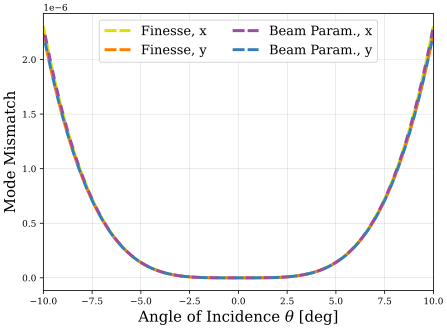

In [22]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 5,))

ax.plot(angleoi, mismatchsx_1, lw=3, ls=(0, (3, 3)), color=CB_color_cycle[8], label=f"Finesse, x")
ax.plot(angleoi, mismatchsy_1, ls=(0, (3, 3)), lw=3, color=CB_color_cycle[1], label=f"Finesse, y")

ax.plot(angleoi, MMx_vals, lw=3, ls=(3, (3, 3)), color=CB_color_cycle[5], label=f"Beam Param., x")
ax.plot(angleoi, MMy_vals, ls=(3, (3, 3)), lw=3, color=CB_color_cycle[0], label=f"Beam Param., y")


ax.ticklabel_format(axis='y', style='sci', scilimits=(1,4))

ax.set_xlabel(r'Angle of Incidence $\theta$ [deg]', fontsize=15)
ax.set_ylabel('Mode Mismatch', fontsize=15);
legend = ax.legend(fontsize=13, ncols=2, loc="best");

legend_lines = legend.get_lines()
for line in legend_lines:
    line.set_linestyle((0, (4, 1)))

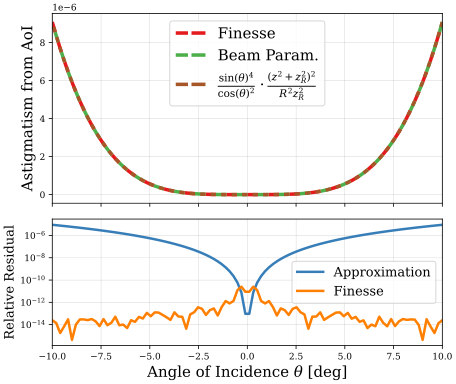

In [23]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(7, 6,), sharex=True, gridspec_kw=dict(height_ratios=[3, 2]))
plt.subplots_adjust(hspace=0.1) 

ax.plot(angleoi, mismatchsxy_1, ls=(0, (3, 3)), lw=3.5, color=CB_color_cycle[7], label=f"Finesse")

ax.plot(angleoi, MMxy_vals, ls=(3, (3, 3)), lw=3.5, color=CB_color_cycle[2], label=f"Beam Param.")

# formula_est = r"$\cdot \left(\frac{R_{c}}{R}\right)^2 \left(\frac{z}{z_{R}}\right)^2$"
formula_est = r"$\frac{\sin(\theta)^4}{\cos(\theta)^2} \cdot \frac{(z^2+z_{R}^2)^2}{R^2z_{R}^2}$"
ax.plot(angleoi, MMxy_expanded_vals, ls=(1.5, (1.5, 1.5)), lw=3.5, color=CB_color_cycle[4], 
        label=formula_est)

# ax1.semilogy(angleoi, np.abs((mismatchsxy_1-MMxy_vals)/MMxy_vals))
ax1.semilogy(angleoi, np.abs((MMxy_expanded_vals-MMxy_vals)/MMxy_vals), lw=2.5, color=CB_color_cycle[0], label="Approximation");
ax1.semilogy(angleoi, np.abs((mismatchsxy_1-MMxy_vals)/MMxy_vals), lw=2.5, color=CB_color_cycle[1], label="Finesse");

ax.ticklabel_format(axis='y', style='sci', scilimits=(1,4))

ax1.set_xlabel(r'Angle of Incidence $\theta$ [deg]', fontsize=15)
ax.set_ylabel('Astigmatism from AoI', fontsize=15);
ax1.set_ylabel('Relative Residual', fontsize=13);
legend = ax.legend(fontsize=15, ncols=1, loc="best");
legend1 = ax1.legend(fontsize=13, ncols=1, loc="best");

legend_lines = legend.get_lines()
for line in legend_lines:
    line.set_linestyle((0.5, (4, 1)))

In [24]:
z_val = 0
w0_val = 1e-3*(1 + 0.5*np.linspace(-0.1, 1, 100))
zR_val = np.pi*w0_val**2/(1064e-9)
R_val = 30
theta_vals = np.linspace(-10, 10, 100) * np.pi / 180
zR_valss, theta_valss = np.meshgrid(zR_val, theta_vals)

# Calculate the results
MMx_2d_vals = MMx_func(z_val, zR_valss, R_val, theta_valss)
MMy_2d_vals = MMy_func(z_val, zR_valss, R_val, theta_valss)
MMxy_2d_vals = MMxy_func(z_val, zR_valss, R_val, theta_valss)

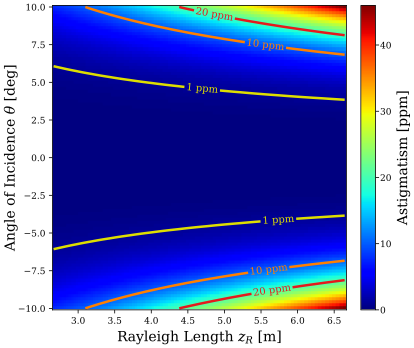

In [34]:
fig, ax = plt.subplots(figsize=(5.8, 5.5,))

img = ax.pcolormesh(zR_valss, theta_valss*180/np.pi, MMxy_2d_vals*1e6, 
                    cmap='jet', 
                    rasterized=True, 
                    antialiased=True,)

ax.set_xlabel(r"Rayleigh Length $z_{R}$ [m]", fontsize=14, labelpad=5)
ax.set_ylabel(r"Angle of Incidence $\theta$ [deg]", fontsize=14, labelpad=0)

ax.set_aspect('auto')
ax.grid(False)

contours = ax.contour(zR_valss,
                      theta_valss*180/np.pi,
                      MMxy_2d_vals*1e6,
                      np.array([1, 10, 20]),
                      colors=[CB_color_cycle[8], CB_color_cycle[1], CB_color_cycle[7]], linewidths=2.5)

fmt = {}
strs = [
    '1 ppm',
    '10 ppm',
    '20 ppm',
]
for l, s in zip(contours.levels, strs):
    fmt[l] = s

ax.clabel(contours, inline=True, rightside_up=True, fmt=fmt, fontsize=10)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(img, cax=cax,)
cbar.set_label(label=r"Astigmatism [ppm]", fontsize=14, rotation=90, labelpad=5)
cbar.set_ticks([0, 10, 20, 30, 40])
cbar.ax.tick_params(labelsize=9, rotation=0, pad=1);

$$
\mbox{Astigmatism: }\frac{\left(z^{2} + z_{R}^{2}\right)^{2} \sin^{4}{\left(\theta \right)}}{- R^{2} z_{R}^{2} \sin^{2}{\left(\theta \right)} + R^{2} z_{R}^{2} + z^{4} \sin^{4}{\left(\theta \right)} + 2 z^{2} z_{R}^{2} \sin^{4}{\left(\theta \right)} + z_{R}^{4} \sin^{4}{\left(\theta \right)}}
\approx \frac{\left(z^{2} + z_{R}^{2}\right)^{2}}{R^{2} z_{R}^{2}} \cdot \frac{\sin^{4}{\left(\theta \right)}}{\cos^{2}{\left(\theta \right)}}
$$

In [26]:
theta = symbols('theta', real=True)
ang_factor = sp.sin(theta)**4/sp.cos(theta)**2
ang_factor_d = sp.diff(ang_factor, theta)
ang_factor

sin(theta)**4/cos(theta)**2

In [27]:
ang_factor_d

2*sin(theta)**5/cos(theta)**3 + 4*sin(theta)**3/cos(theta)

In [28]:
ang_factor_func = lambdify((theta,), ang_factor, 'numpy')
ang_factor_d_func = lambdify((theta,), ang_factor_d, 'numpy')

In [29]:
theta_vals = np.linspace(-45, 45, 801) * np.pi / 180
ang_factor_val = ang_factor_func(theta_vals)
ang_factor_d_val = ang_factor_d_func(theta_vals)

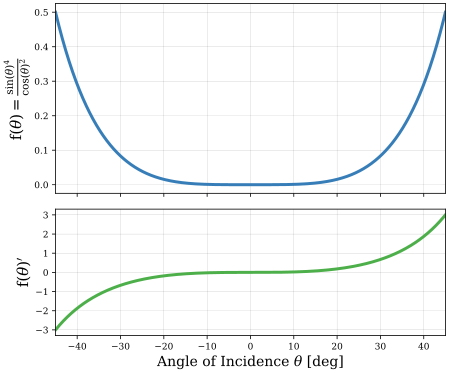

In [30]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(7, 6,), sharex=True, gridspec_kw=dict(height_ratios=[3, 2]))
plt.subplots_adjust(hspace=0.1) 

ax[0].plot(theta_vals*180/np.pi, ang_factor_val, lw=3, color=CB_color_cycle[0])
ax[1].plot(theta_vals*180/np.pi, ang_factor_d_val, lw=3, color=CB_color_cycle[2])

ax[1].set_xlabel(r'Angle of Incidence $\theta$ [deg]', fontsize=14)
ax[0].set_ylabel(r'$\mathrm{f}(\theta) = \frac{\sin(\theta)^4}{\cos(\theta)^2}$', fontsize=15);
ax[1].set_ylabel(r'$\mathrm{f}(\theta)^{\prime}$', fontsize=15);